In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
data = np.loadtxt('LHC_data_2023.txt')
min(data), max(data), len(data)

(np.float64(20.0), np.float64(40.0), 100000)

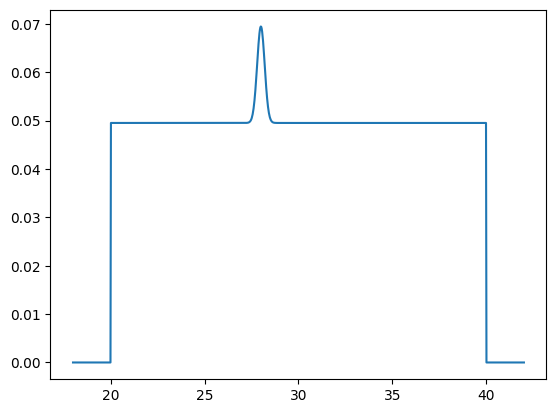

In [15]:
M = 35 # GeV

def pdf_bkg(x):
    return sp.stats.uniform(loc=min(data), scale=max(data)-min(data)).pdf(x)

def pdf(xm, m=35, f=0.01):
    a, b = (min(data) - m) / 0.2, (max(data) - m) / 0.2
    return (1-f)*sp.stats.uniform(loc=min(data), scale=max(data)-min(data)).pdf(xm) + f*sp.stats.truncnorm(a, b, loc=m, scale=0.2).pdf(xm)
    return (1-0.01)*sp.stats.uniform(loc=min(data), scale=max(data)-min(data)).pdf(xm) + 0.01*sp.stats.norm(loc=m, scale=0.2).pdf(xm)

def gen_bkg(N):
    return sp.stats.uniform(loc=min(data), scale=max(data)-min(data)).rvs(N)

def gen_sig(N, m=35):
    return sp.stats.norm(loc=m, scale=0.2).rvs(N)

x = np.linspace(min(data)-2, max(data)+2, 1000)
plt.plot(x, pdf(x, 28))

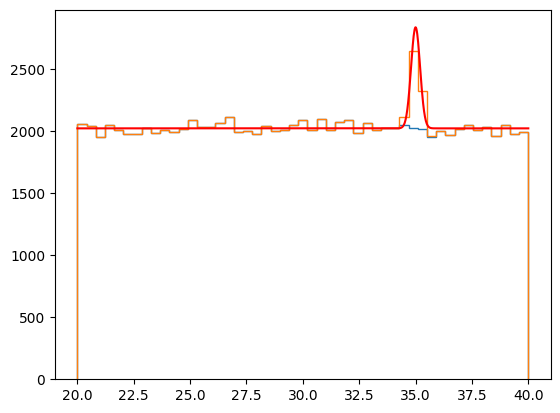

In [5]:
mc_bkg = gen_bkg(int(len(data)*0.99))
mc_sig = gen_sig(int(len(data)*0.01))

bins = np.linspace(min(data), max(data), 50)
bin_center = (bins[1:] + bins[:-1])/2

bkg_counts, bins = np.histogram(mc_bkg, bins=bins)
sig_counts, bins = np.histogram(mc_sig, bins=bins)

plt.stairs(bkg_counts, bins)
plt.stairs(sig_counts+bkg_counts, bins)

x = np.linspace(min(data), max(data), 1000)
plt.plot(x, pdf(x)*len(data)*np.diff(bins)[0], 'r')

In [18]:

def chi2(data, pred):
    return np.sum((data - pred)**2 / pred)

def chi2red(data, pred):
    return chi2(data, pred)/len(data)

pred = pdf_bkg(bin_center)*len(data)*np.diff(bins)[0]


In [32]:
def pred(m,f):
    return pdf(bin_center, m, f)*len(data)*np.diff(bins)[0]

def nll(data, m, f):
    return chi2(data, pred(m,f))

def log_prior(m,f):
    pm = 0 if 20 <= m <= 40 else -np.inf
    sigmaf = 0.01
    pf = -0.5 * ((f-0.01)/sigmaf)**2
    return pm*pf

In [33]:
def log_posterior(data, m, f):
    """Log-posterior proportional to log-likelihood + log-prior."""
    return nll(data, m, f) + log_prior(m,f)

# Metropolis-Hastings Algorithm with log-probabilities
def metropolis_hastings_log(iterations, initial, proposal_std, data):
    samples = [initial]
    current = initial
    log_current = log_posterior(data, current[0], current[1])
    
    for _ in range(iterations):
        # Propose new candidate
        proposal = np.random.normal(loc=current, scale=proposal_std, size=2)
        log_proposal = log_posterior(data, proposal[0], proposal[1])
        
        # Compute log acceptance ratio
        log_alpha = min(0, log_proposal - log_current)
        
        # Accept/reject step
        if np.log(np.random.rand()) < log_alpha:
            current = proposal  # Accept proposal
            log_current = log_proposal
        
        samples.append(current)
    
    return np.array(samples)

iterations = 10000
initial = [30, 0.01]  # Starting values for [beta0, beta1]
proposal_std = [0.5, 0.005]  # Standard deviation of proposal distribution

# Run Metropolis-Hastings
samples = metropolis_hastings_log(iterations, initial, proposal_std, pred(30, 0.01))

/tmp/ipykernel_42997/3311108667.py:17: RuntimeWarning: invalid value encountered in scalar subtract
  log_alpha = min(0, log_proposal - log_current)


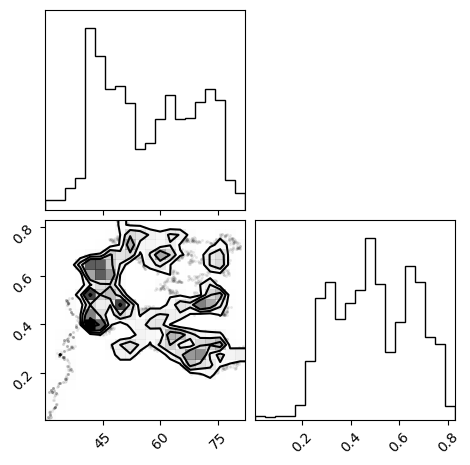

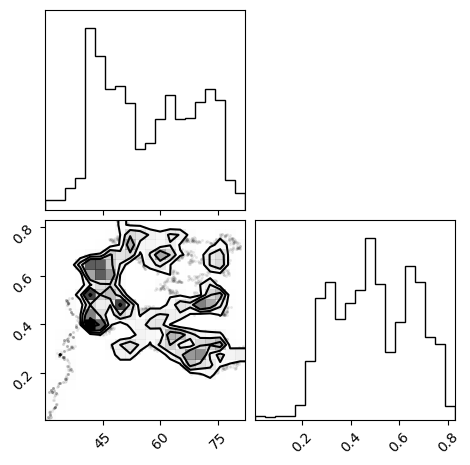

In [34]:
import corner
corner.corner(samples)